# Inspect Nucleus Trained Model

In [0]:
%tensorflow_version 1.x
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ROOT_DIR = os.path.abspath("./")

sys.path.append(ROOT_DIR)  
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import nucleus

%matplotlib inline 

LOGS_DIR = os.path.join(ROOT_DIR, "logs")

## Configurations

In [6]:
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/nucleus")
config = nucleus.NucleusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1

## Notebook Preferences

In [0]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [9]:
dataset = nucleus.NucleusDataset()
dataset.load_nucleus(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 25
Classes: ['BG', 'nucleus']


## Load Model

In [10]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [11]:
weights_path = "./mask_rcnn_nucleus.h5"
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ./mask_rcnn_nucleus.h5








## Run Detection

image ID: nucleus.4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06 (20) 4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06
Original image shape:  [256 320   3]
Processing 1 images
image                    shape: (512, 640, 3)         min:    1.00000  max:  229.00000  uint8
molded_images            shape: (1, 512, 640, 3)      min:    1.00000  max:  229.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 81840, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (12, 4)               min:    4.00000  max:  588.00000  int32
gt_mask                  shape: (512, 640, 12)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.795
AP @0.55:	 0.795
AP @0.60:	 0.689
AP @0.65:	 0.532
AP @0.70:	 0.268
AP @0.75:	 0.268
AP @0.80:	 0.268
AP @0.85:	

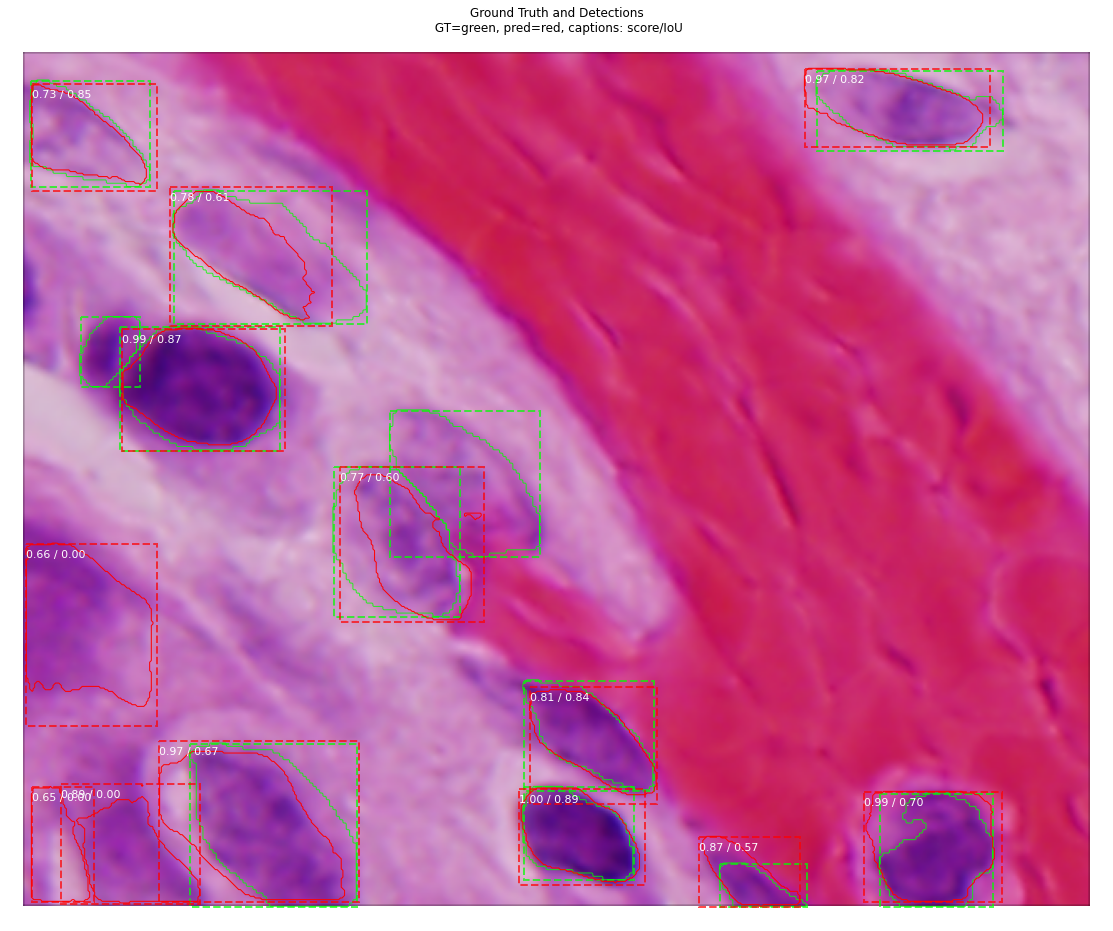

In [14]:
image_id = 20 #random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=True, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

### Compute AP on Batch of Images

In [16]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

limit = 5
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP over {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [256 320   3]   AP: 0.41
  1 [256 320   3]   AP: 0.35
  2 [256 320   3]   AP: 0.54
  3 [1040 1388    3]   AP: 0.74
  4 [256 320   3]   AP: 0.25
Mean AP over 5 images: 0.4601


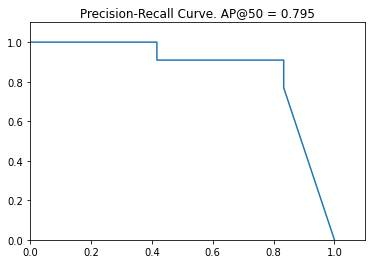

In [17]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks']) 
visualize.plot_precision_recall(AP, precisions, recalls)